In [1]:
# set same dependency environment to ./Utils/Tracker.py, so python files in this script can access the same environment as Tracker.py
import sys
sys.path.append(r'D:\CodeRepos\Lidar-Tracker\LiDAR_Tracker_Project_v3.1\Interface\Utils')

from DDBSCAN import Raster_DBSCAN
from LiDARBase import *
from GenBckFile import *
from SaveTrajectoryTools import save_result
from ExamPcapStartTime import get_pcap_start_time
import pandas as pd
import os
from p_tqdm import p_umap
from functools import partial
from threading import Thread,Event

In [76]:
pcap_file_path = r'D:\LiDAR_Data\US50ANDHighlands\2024-03-16-12-30-00.pcap'
tracking_parameter_dict = {
        'win_width': 13,
        'win_height': 7,
        'eps': 1,
        'min_samples': 10,
        'missing_thred': 5,
        'bck_radius': 0.2,
        'N' : 10,
        'd_thred' : 0.1,
    }
termination_event = Event()
thred_map = gen_bckmap(pcap_file_path, 
                        N = tracking_parameter_dict['N'],
                        d_thred = tracking_parameter_dict['d_thred'],
                        bck_n = 3,
                        termination_event = termination_event)
start_timestamp = get_pcap_start_time(pcap_file_path)
packets_gen = read_packets_offline(pcap_file_path)
frame_generator = parse_packets(packets_gen)

17987it [06:44, 44.48it/s]


In [80]:
UTC_time_diff = 0
if_save_point_cloud = True
point_cloud_path = r'D:\LiDAR_Data\Test'

In [238]:
mot = MOT(tracking_parameter_dict,thred_map)
mot.UTC_time_diff = UTC_time_diff
if if_save_point_cloud:
    mot.point_cloud_save_path = point_cloud_path
mot.start_timestamp = start_timestamp

In [239]:
while not mot.if_initialized:
    try:
        frame = next(frame_generator)
    except StopIteration:
        break
    mot.initialization(frame)

    if if_save_point_cloud:
        save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
    # break

In [422]:
frame = next(frame_generator)
mot.mot_tracking_step(frame)
# save_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,point_cloud_path,mot.CurFrame,mot.Tracking_pool)
fore_points = get_fore_pcd(mot.cur_Td_map,mot.cur_Labeling_map,mot.Tracking_pool)
cur_frame = mot.CurFrame
cur_labeling_map = mot.cur_Labeling_map
cur_td_map = mot.cur_Td_map

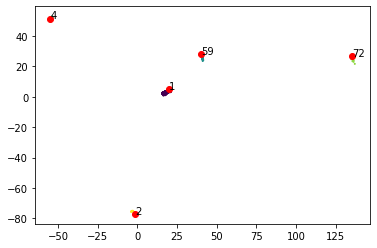

In [423]:
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3])
for key in mot.Tracking_pool.keys():
    if mot.Tracking_pool[key].label_seq[-1] != -1:
        plt.scatter(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],c = 'r')
        plt.text(mot.Tracking_pool[key].mea_seq[-1][0][0][0],mot.Tracking_pool[key].mea_seq[-1][0][1][0],str(key))
plt.show()

In [424]:
# point cloud is in .npy format [x,y,z,obj_label]
point_cloud_folder = r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out'
pc_folders = os.listdir(point_cloud_folder)
for folder in pc_folders:
    frame_names = os.listdir(os.path.join(point_cloud_folder, folder))
    total_point_clouds = []
    for frame in frame_names:
        point_cloud = np.load(os.path.join(point_cloud_folder, folder, frame))
        total_point_clouds.append(point_cloud)
    break
total_point_clouds_frame = np.concatenate(total_point_clouds, axis=0)

In [428]:
trajectory_data = pd.read_csv(r'D:\LiDAR_Data\US50ANDHighlands\test_traj_out\2024-03-16-12-30-00.csv')

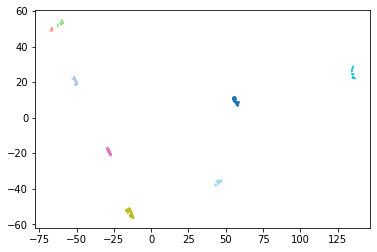

In [432]:
fore_points = np.load(r'D:\LiDAR_Data\US50ANDHighlands\test_point_cloud_out\2024-03-16-12-30-00\10.npy')
plt.scatter(fore_points[:,0],fore_points[:,1],s = 1,c = fore_points[:,3],cmap = 'tab20')
plt.show()

In [1]:
import cv2
import ultralytics

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\zhChe\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# Open the video file
input_path = r'D:\LiDAR_Data\00_00_192.168.1.108_1_20241204_183000.avi'
output_path = r'D:\LiDAR_Data\test_clip.avi'
cap = cv2.VideoCapture(input_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Width of the frame
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Height of the frame
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
# Calculate frame indices for start and end times
start_frame = 100
end_frame = 300

# Set up VideoWriter for saving the output
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
# Set the starting position of the video
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
# Loop through frames and save to the output
current_frame = start_frame
while current_frame < end_frame:
    ret, frame = cap.read()
    if not ret:
        print("End of video reached or error reading frame.")
        break

    out.write(frame)
    current_frame += 1

# Release resources
cap.release()
out.release()

In [1]:
import torch
from ultralytics import YOLO
from PIL import Image


In [2]:
# Load a model
model = YOLO("yolo11x-pose.pt")  # load an official model
# use GPU if available
model = model.cuda()